In [1]:
from dataclasses import dataclass

import random
import numpy as np
import sys, os

import matplotlib.pyplot as plt

class RandomTraceError(Exception): pass

@dataclass
class GLOBAL():
    
    # electronics constants set in offline, see Framework/SDetector/SdSimCalibrationConstants.xml.in
    q_peak                      = 215.934                                       # calibration factor for ADC - VEM
    q_charge                    = 1606.467                                      # calibration factor for integrals

    # Trace details, can be overwritten in __new__ of EventGenerator
    background_frequency        = 4665                                          # frequency of accidental injections / Hz
    single_bin_duration         = 8.3e-9                                        # time length of a single bin, in s                                               
    n_bins                      = 2048                                          # 1 Bin = 8.3 ns, 2048 Bins = ~17. us
    baseline_std                = 2                                             # two ADC counts, NOT converted here!
    baseline_mean               = 0                                             # gaussian mean of the actual baseline
    real_background             = False                                         # use random traces instead of gaussian baseline
    random_index                = None                                          # this file is used first when creating randoms
    force_inject                = None                                          # whether or not to force injection of muons
    station                     = None                                          # what station to use for random traces

    # trace_opts                  = [q_peak, q_charge, length, sigma, mu, n_injected, downsampling]

    # Generator details, can be overwritten in __new__ of EventGenerator
    split                       = 0.8                                           # Ratio of the training / validation events
    prior                       = 0.5                                           # Probability of a signal event in the data
    seed                        = False                                         # make RNG dice rolls reproducible via seed
    full_trace                  = False                                         # return entire trace instead of sliding window
    downsampling                = False                                         # make UUB traces look like UB ones instead
    
    # Classifier details, can be overwritten in __new__ of EventGenerator
    ignore_low_VEM              = 0                                             # label signals under threshold as background
    window                      = 120                                           # Length (in bins) of the sliding window
    step                        = 10                                            # Sliding window analysis step size (in bins)
    early_stopping_patience     = 10000                                         # number of batches for early stopping patience
    n_production_traces         = int(1e6)                                      # how many random traces to look at for predictions
    n_ensembles                 = 10                                            # how many networks of same architecture to train

class RandomTrace():

    baseline_dir = "/cr/tempdata01/filip/iRODS/"                                      # storage path of the station folders
    # all_files : np.ndarray = np.asarray(os.listdir(baseline_dir))                   # container for all baseline files
    # all_n_files : int = len(all_files)                                              # number of available baseline files

    def __init__(self, station = None, index = None): 

        ## (HOPEFULLY) TEMPORARILY FIXED TO NURIA/LO_QUI_DON DUE TO BAD FLUCTUATIONS IN OTHER STATIONS
        self.station = random.choice(["nuria", "lo_qui_don"]) if station is None else station.lower()
        self.index = index

        all_files = np.asarray(os.listdir(RandomTrace.baseline_dir + self.station)) # container for all baseline files
        self.all_n_files = len(all_files)                                           # number of available baseline files

        self.__current_traces = 0                                                   # number of traces already raised

        if index is None:
            self.random_file = all_files[np.random.randint(self.all_n_files)]
        else:
            try:
                self.random_file = all_files[index]
            except IndexError:
                raise RandomTraceError

        print(f"[INFO] -- LOADING RANDOMS: {self.random_file}" + 20 * " ")

        these_traces = np.loadtxt(RandomTrace.baseline_dir + self.station + "/" + self.random_file)

        # IF YOU WANT TO USE DAY AVERAGE FROM ONLINE ESTIMATE #########################################
        # values come from $TMPDATA/iRODS/MonitoringData/read_monitoring_data.ipynb -> monitoring files
        if "nuria" in self.random_file:
            self.q_peak = [180.23, 182.52, 169.56]
            self.q_charge = [3380.59, 3508.69, 3158.88]
        elif "lo_qui_don" in self.random_file:
            # self.q_peak = [164.79, 163.49, 174.71]
            self.q_peak = [163.79, 162.49, 173.71]
            self.q_charge = [2846.67, 2809.48, 2979.65]
        elif "jaco" in self.random_file:
            self.q_peak = [189.56, 156.48, 168.20]
            self.q_charge = [3162.34, 2641.25, 2840.97]
        elif "peru" in self.random_file:
            self.q_peak = [164.02, 176.88, 167.37]
            self.q_charge = [2761.37, 3007.72, 2734.63]
        else:
            print("Station not found! THIS SHOULD NOT HAPPEN")
            self.q_peak = [GLOBAL.q_peak for i in range(3)]
            self.q_charge = [GLOBAL.q_charge for i in range(3)]

        self._these_traces = np.split(these_traces, len(these_traces) // 3)         # group random traces by pmt


    # get random traces for a single stations
    def get(self): 
        
        try:                                                                        # update pointer after loading
            self.__current_traces += 1

            return self.q_peak, self.q_charge, self._these_traces[self.__current_traces]
        
        except IndexError:                                                          # reload buffer on overflow

            try:
                self.__init__(station = self.station, index = self.index + 1)
            except TypeError:
                self.__init__(station = self.station)

            return self.get()

class HardwareClassifier():

    def __init__(self, name= False): 
        self.name = name or "HardwareClassifier"

    def __call__(self, trace ): 
        
        # Threshold of 3.2 immediately gets promoted to T2
        # Threshold of 1.75 if a T3 has already been issued

        try:
            return self.Th(3.2, trace) or self.ToT(trace) or self.ToTd(trace) or self.MoPS(trace)
        except ValueError:
            return np.array([self.__call__(t) for t in trace])

    # method to check for (coincident) absolute signal threshold
    def Th(self, threshold, signal): 

        pmt_1, pmt_2, pmt_3 = signal

        # hierarchy doesn't (shouldn't?) matter
        for i in range(signal.shape[1]):
            if pmt_1[i] >= threshold:
                if pmt_2[i] >= threshold:
                    if pmt_3[i] >= threshold:
                        return True
                    else: continue
                else: continue
            else: continue
        
        return False

    # method to check for elevated baseline threshold trigger
    def ToT(self, signal): 

        threshold     = 0.2      # bins above this threshold are 'active'
        
        pmt_1, pmt_2, pmt_3 = signal

        # count initial active bins
        pmt1_active = list(pmt_1 > threshold).count(True)
        pmt2_active = list(pmt_2 > threshold).count(True)
        pmt3_active = list(pmt_3 > threshold).count(True)
        ToT_trigger = [pmt1_active >= 13, pmt2_active >= 13, pmt3_active >= 13]

        if ToT_trigger.count(True) >= 2:
            return True
        else:
            return False

    # method to check for elevated baseline of deconvoluted signal
    # first bin of trace is ignored, this shouldn't matter too much hopefully
    def ToTd(self, signal): 

        # for information on this see GAP note 2018-01
        dt      = 8.3                                                               # UUB bin width
        tau     = 67                                                                # decay constant
        decay   = np.exp(-dt/tau)                                                   # decay term
        deconvoluted_trace = []

        for pmt in signal:
            deconvoluted_pmt = [(pmt[i] - pmt[i-1] * decay)/(1 - decay) for i in range(1,len(pmt))]
            deconvoluted_trace.append(deconvoluted_pmt)
 
        return self.ToT(np.array(deconvoluted_trace))

    # method to count positive flanks in an FADC trace
    def MoPS(self, signal): 

        # as per GAP note 2018-01; an exact offline reconstruction of the trigger is not possible
        # Can this be fixed in some way? perhaps with modified integration threshold INT?
        return False 

def apply_downsampling(trace):

    # ensure downsampling works as intended
    # cuts away (at most) the last two bins
    if trace.shape[-1] % 3 != 0:
        trace = np.array([pmt[0 : -(trace.shape[-1] % 3)] for pmt in trace])

    # see /cr/data01/filip/offline/trunk/Framework/SDetector/UUBDownsampleFilter.h for more information
    kFirCoefficients = [ 5, 0, 12, 22, 0, -61, -96, 0, 256, 551, 681, 551, 256, 0, -96, -61, 0, 22, 12, 0, 5 ]
    buffer_length = int(0.5 * len(kFirCoefficients))
    kFirNormalizationBitShift = 11
    # kADCsaturation = 4095                             # bit shift not really needed

    n_bins_uub      = np.shape(trace)[1]                # original trace length
    n_bins_ub       = int(n_bins_uub / 3)               # downsampled trace length
    sampled_trace   = np.zeros((3, n_bins_ub))          # downsampled trace container

    temp = np.zeros(n_bins_uub + len(kFirCoefficients))

    for i_pmt, pmt in enumerate(trace):

        temp[0 : buffer_length] = pmt[:: -1][-buffer_length - 1 : -1]
        temp[-buffer_length - 1: -1] = pmt[:: -1][0 : buffer_length]
        temp[buffer_length : -buffer_length - 1] = pmt

        # perform downsampling
        for j, coeff in enumerate(kFirCoefficients):
            sampled_trace[i_pmt] += [temp[k + j] * coeff for k in range(0, n_bins_uub, 3)]

    # clipping and bitshifting
    for i, pmt in enumerate(sampled_trace):
        for j, adc in enumerate(pmt):
            sampled_trace[i,j] = np.clip(int(adc) >> kFirNormalizationBitShift, a_min = -20, a_max = None)
            # sampled_trace[i,j] = int(adc) >> kFirNormalizationBitShift

    return sampled_trace

In [2]:
trace_duration = GLOBAL.n_bins * GLOBAL.single_bin_duration

Buffer = RandomTrace(station = "nuria", index = 0)
window_start = range(0, 682 - 120, 1)
window_stop = range(120, 682, 1)
Trigger = HardwareClassifier()

[INFO] -- LOADING RANDOMS: nuria_randoms0001.csv                    


StopIteration: 

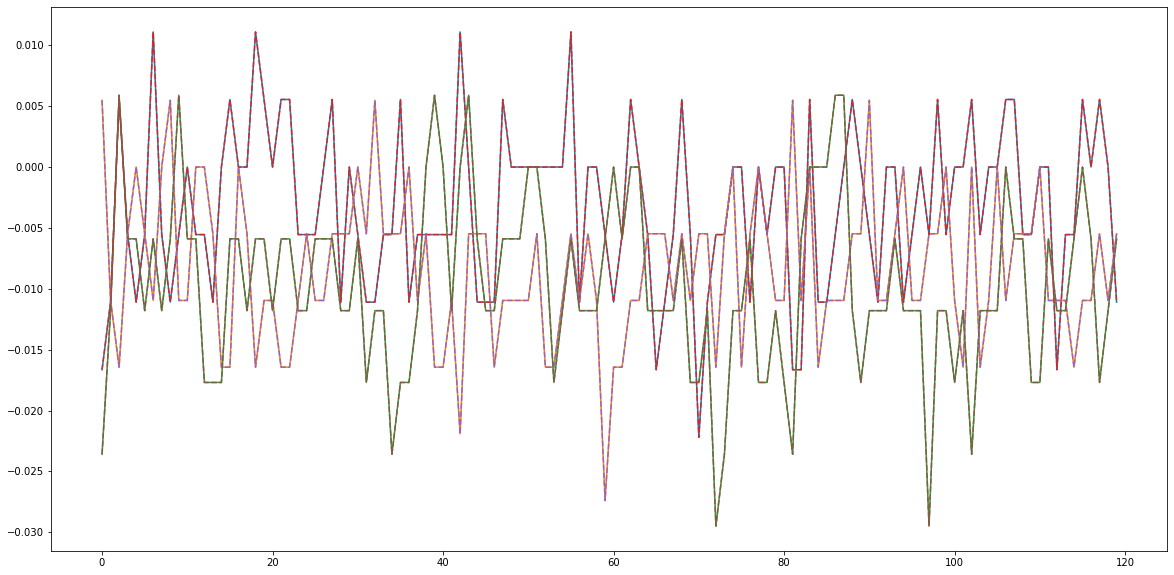

In [8]:
for j, trace in enumerate(Buffer._these_traces):

    # apply downsampling to trace
    downsampled_trace = apply_downsampling(trace)

    for i, (start, stop) in enumerate(zip(window_start, window_stop)):

        signal_1vem = np.array([downsampled_trace[k, start : stop] / (Buffer.q_peak[k] - 0) for k in range(3)])
        signal_10vem = np.array([downsampled_trace[k, start : stop] / (Buffer.q_peak[k] - 0.01) for k in range(3)])

        plt.plot(range(len(signal_1vem[0])), signal_1vem[0])
        plt.plot(range(len(signal_1vem[1])), signal_1vem[1])
        plt.plot(range(len(signal_1vem[2])), signal_1vem[2])

        plt.plot(range(len(signal_10vem[0])), signal_10vem[0], ls = "--")
        plt.plot(range(len(signal_10vem[1])), signal_10vem[1], ls = "--")
        plt.plot(range(len(signal_10vem[2])), signal_10vem[2], ls = "--")

        raise StopIteration

# plt.ylim(-0.02, 0.02)
# plt.yscale()

In [3]:
plt.rcParams["figure.figsize"] = [20, 10]

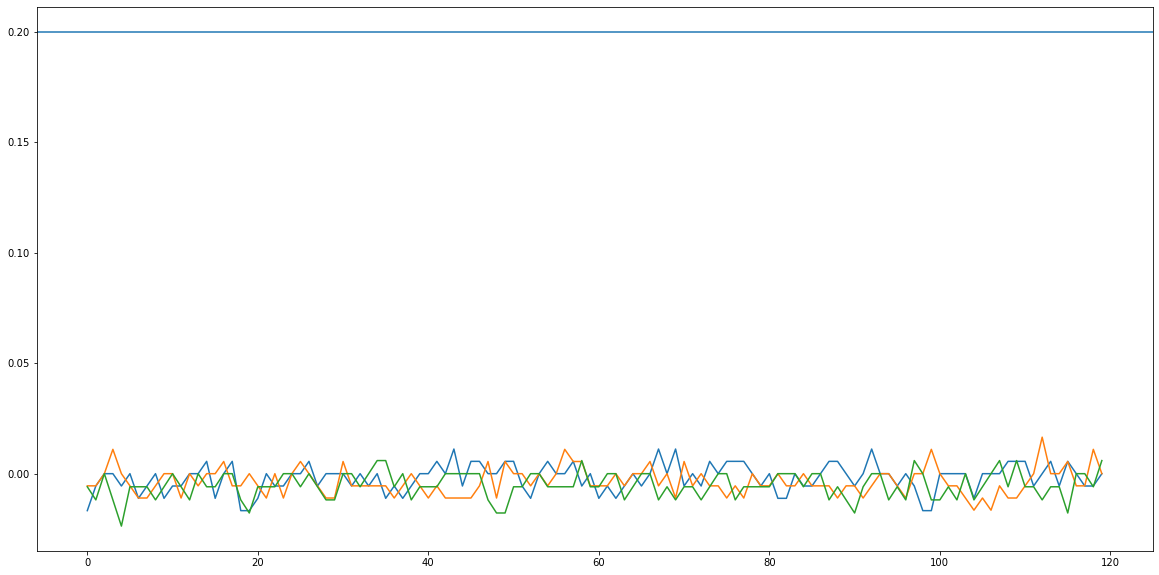

In [7]:
plt.plot(range(len(signal_1vem[0])), signal_1vem[0])
plt.plot(range(len(signal_1vem[1])), signal_1vem[1])
plt.plot(range(len(signal_1vem[2])), signal_1vem[2])
plt.axhline(0.2)

In [8]:
print(Trigger.ToT(signal_1vem))

False
